In [ ]:
from IPython.display import HTML

HTML(
    """<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>"""
)

In [ ]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install bertopic
!{sys.executable} -m pip install nltk 
!{sys.executable} -m pip install textblob

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bertopic import BERTopic
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
from textblob import TextBlob

In [4]:
survey_April20 = pd.read_csv('Data/ProlificAcademic/updated_data/April/CRISIS_Adult_April_2020.csv',index_col='ID')

In [5]:
survey_May20 = pd.read_csv('Data/ProlificAcademic/updated_data/May/CRISIS_Adult_May_2020.csv',index_col='ID')

In [6]:
survey_Nov20 = pd.read_csv('Data/ProlificAcademic/updated_data/November/CRISIS_Adult_November_2020.csv',index_col='ID')

C:\Users\MSUSERSL123\anaconda3\envs\crisisml\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (93) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
survey_April21 = pd.read_csv('Data/ProlificAcademic/updated_data/April_21/CRISIS_Adult_April_2021.csv',index_col='ID')

C:\Users\MSUSERSL123\anaconda3\envs\crisisml\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (5,77,78) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
# check individual row and column dimensions
print(survey_April20.shape)
print(survey_May20.shape)
print(survey_Nov20.shape)
print(survey_April21.shape)

(2868, 243)
(3148, 108)
(2223, 289)
(2125, 285)


In [9]:
# cant use merge as columns are not same
# survey_df = pd.merge(survey_April20, survey_Nov20, how="inner", on='ID')

### Find common participants across all groups

In [10]:
series_1 = pd.Series(np.intersect1d(survey_April20.index,survey_May20.index, assume_unique=True))
series_2 = pd.Series(np.intersect1d(survey_Nov20.index,survey_April21.index, assume_unique=True))
unique_ids = list(pd.Series(np.intersect1d(series_1,series_2,assume_unique=True)))
#pd.Series(np.intersect1d(pd.Series([1,2,3,5,42]), pd.Series([4,5,6,20,42])))a

In [11]:
len(unique_ids)

1184

In [12]:
# Test entry in a dataframe
print('location' in survey_April20.columns)
survey_April21.loc['00db60f1','location']

True


4.0

In [13]:
## filter rows
survey_April20 = survey_April20.loc[unique_ids]
survey_May20 = survey_May20.loc[unique_ids]
survey_Nov20 = survey_Nov20.loc[unique_ids]
survey_April21 = survey_April21.loc[unique_ids]

In [14]:
## Compare shapes after filtering
print(survey_April20.shape)
print(survey_May20.shape)
print(survey_Nov20.shape)
print(survey_April21.shape)

(1184, 243)
(1184, 108)
(1184, 289)
(1184, 285)


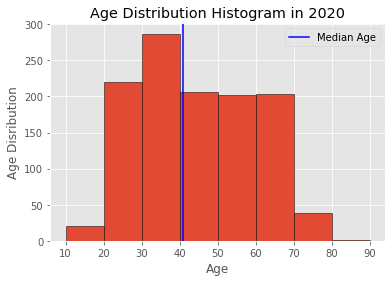

In [15]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
ages = survey_Nov20['age']
bins = list(range(10,100,10))
median_age = survey_Nov20['age'].median()
plt.hist(ages, bins=bins, edgecolor='black')
plt.axvline(median_age, color='blue', label="Median Age")
plt.xlabel("Age")
plt.ylabel("Age Disribution")
plt.title("Age Distribution Histogram in 2020")
plt.legend()
plt.show()

7.0    367
4.0    314
5.0    273
3.0    142
2.0     49
6.0     34
1.0      1
Name: education, dtype: int64

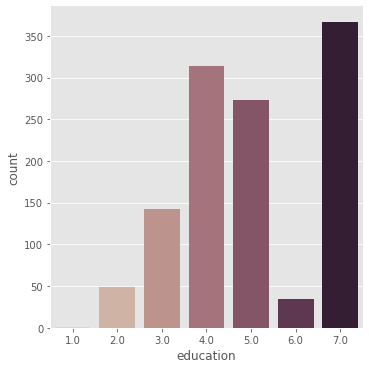

In [16]:
#Education bar chart

sns.catplot(x="education", kind="count", palette="ch:.25", data=survey_April20)
survey_April20['education'].value_counts()

In [17]:
# Find common columns - ignore May 20 as column size decreases drastically
surveys = [survey_April20,survey_Nov20,survey_April21]

common_cols_timeseries = list(set.intersection(*(set(df.columns) for df in surveys)))

In [18]:
# Python map function to subset columns for all dataframes

#subset_df = list(map(lambda s:s[common_cols_timeseries], surveys))
survey_April20_min = survey_April20[common_cols_timeseries]
survey_Nov20_min = survey_Nov20[common_cols_timeseries]
survey_April21_min = survey_April21[common_cols_timeseries]


In [19]:
survey_April21_min = survey_April21_min.add_suffix('_April21')

In [20]:
## Column datatypes

survey_April20_min.dtypes

symptoms___8               int64
householdcomp___7          int64
inpersonconvo_bin        float64
impact___4                 int64
disruptedsupports___5      int64
                          ...   
disruptedsupports___2      int64
working___8                int64
impact___2                 int64
timeoutside              float64
disruptedsupports___7      int64
Length: 107, dtype: object

### Merge dataframes for longitudinal analysis

In [125]:
surveys_df = pd.merge(survey_April20_min, survey_Nov20_min, how="inner", left_index=True, right_index=True, suffixes=('_April20','_Nov20')).merge(survey_April21_min, left_index=True,right_index=True,  how="inner", suffixes=('','_April21'))

In [126]:
sorted(list(surveys_df.columns))

['age_April20',
 'age_April21',
 'age_Nov20',
 'age_bin_April20',
 'age_bin_April21',
 'age_bin_Nov20',
 'contactschanged_April20',
 'contactschanged_April21',
 'contactschanged_Nov20',
 'country_April20',
 'country_April21',
 'country_Nov20',
 'diagnosedfamily___1_April20',
 'diagnosedfamily___1_April21',
 'diagnosedfamily___1_Nov20',
 'diagnosedfamily___2_April20',
 'diagnosedfamily___2_April21',
 'diagnosedfamily___2_Nov20',
 'diagnosedfamily___3_April20',
 'diagnosedfamily___3_April21',
 'diagnosedfamily___3_Nov20',
 'difficultycancellations_April20',
 'difficultycancellations_April21',
 'difficultycancellations_Nov20',
 'difficultydistancing_April20',
 'difficultydistancing_April21',
 'difficultydistancing_Nov20',
 'disruptedsupports___10_April20',
 'disruptedsupports___10_April21',
 'disruptedsupports___10_Nov20',
 'disruptedsupports___11_April20',
 'disruptedsupports___11_April21',
 'disruptedsupports___11_Nov20',
 'disruptedsupports___12_April20',
 'disruptedsupports___12_April

In [127]:
surveys_df.shape

(1184, 321)

### Longitudinal Analysis to depict migration

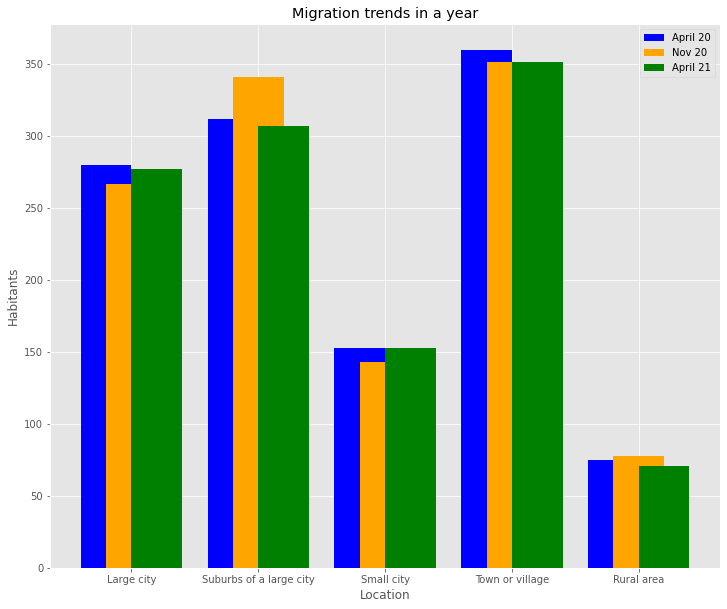

In [128]:
# create data
x = surveys_df['location_April20'].value_counts().sort_index().keys()
y1 = surveys_df['location_April20'].value_counts().sort_index().values
y2 = surveys_df['location_Nov20'].value_counts().sort_index().values
y3 = surveys_df['location_April21'].value_counts().sort_index().values
width = 0.4
  
# plot data in grouped manner of bar type
plt.figure(figsize=(12,10))
plt.title("Migration trends in a year")
plt.bar(x-0.2, y1, width, color='blue')
plt.bar(x, y2, width, color='orange')
plt.bar(x+0.2, y3, width, color='green')
plt.xticks(x, ['Large city', 'Suburbs of a large city', 'Small city', 'Town or village', 'Rural area'])
plt.xlabel("Location")
plt.ylabel("Habitants")
plt.legend(["April 20", "Nov 20", "April 21"])
plt.show()




<AxesSubplot:>

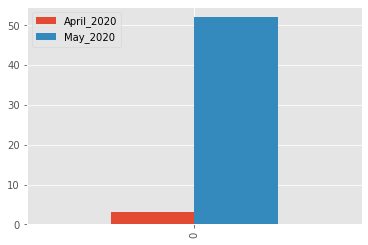

In [130]:
## job losses over a pandemic laid off + losejob

#comparison of Apri and May

jobloss_April = survey_April20.loc[survey_April20['losejob']==1,'losejob'].sum()
jobloss_May   = survey_May20.loc[survey_May20['losejob']==1,'losejob'].sum()

jobloss = {'April_2020':[jobloss_April],'May_2020': [jobloss_May]}

pd.DataFrame(jobloss).plot(kind='bar')

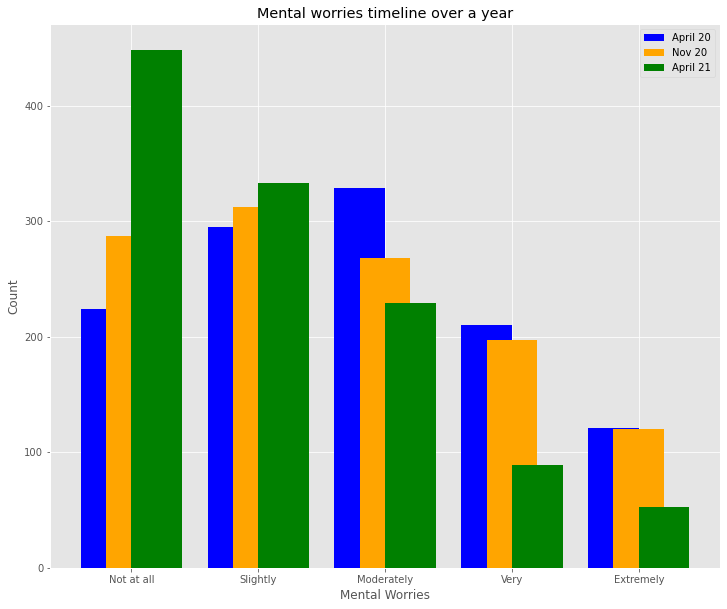

In [131]:
#Longtiduinal Analysis of covidstress and mental worries

# create data
x = surveys_df['worriedmental_April20'].value_counts().sort_index().keys()
y1 = surveys_df['worriedmental_April20'].value_counts().sort_index().values
y2 = surveys_df['worriedmental_Nov20'].value_counts().sort_index().values
y3 = surveys_df['worriedmental_April21'].value_counts().sort_index().values
width = 0.4
  
# plot data in grouped manner of bar type
plt.figure(figsize=(12,10))
plt.title("Mental worries timeline over a year")
plt.bar(x-0.2, y1, width, color='blue')
plt.bar(x, y2, width, color='orange')
plt.bar(x+0.2, y3, width, color='green')
plt.xticks(x, ['Not at all','Slightly','Moderately','Very','Extremely'])
plt.xlabel("Mental Worries")
plt.ylabel("Count")
plt.legend(["April 20", "Nov 20", "April 21"])
plt.show()




### Above chart shows people were not worried at all in April 2021 when vaccinations had started.

In [132]:
def categorical_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', verbose=True):
    '''
    Helper function that gives a quick summary of a given column of categorical data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data, y would be the count
    y: str. vertical axis to plot the labels of categorical data, x would be the count
    hue: str. if you want to compare it another variable (usually the target variable)
    palette: array-like. Colour of the plot
    Returns
    =======
    Quick Stats of the data and also the count plot
    '''
    if x == None:
        column_interested = y
    else:
        column_interested = x
    series = dataframe[column_interested]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.countplot(x=x, y=y, hue=hue, data=dataframe, palette=palette)
    plt.show()


count    220.000000
mean       0.236364
std        0.425817
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: losejob, dtype: float64
mode:  0    0.0
dtype: float64
0.0    168
1.0     52
Name: losejob, dtype: int64


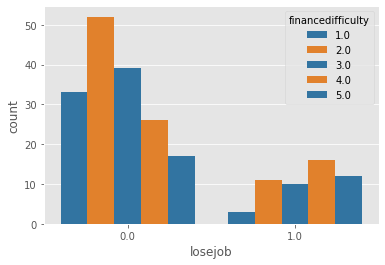

In [133]:
c_palette = ['tab:blue', 'tab:orange']
categorical_summarized(survey_May20, x = 'losejob', hue='financedifficulty', palette=c_palette)

In [134]:
survey_April20.loc[survey_April20['laidoff']==1].shape

(4, 243)

In [183]:
columns = [column for column in survey_Nov20.columns if survey_Nov20[column].dtype == 'object']

In [184]:
columns

['adult_selfreport_baseline_form_timestamp',
 'timestamp1',
 'gender_other',
 'raceethnicitydescribe',
 'sexualorientationother',
 'otherhealth',
 'occupation',
 'othersymptoms',
 'disruptedsupportsother',
 'specifypositive',
 'timestamp2',
 'age_bin']

In [46]:
stop_words_default = set(stopwords.words('english'))

stop_words_file = 'Data/long_stopwords.txt'

stop_words_custom = []

with open(stop_words_file, "r") as f:
    for line in f:
        stop_words_custom.extend(line.split()) 
        
stop_words = list(stop_words_default.union(set(stop_words_custom)))

def preprocess(raw_text):
    
    #regular expression keeping only letters 
    letnum_text =  re.sub("[^a-zA-Z0-9\s]+", " ",raw_text )

    # convert to lower case and split into words -> convert string into list ( 'hello world' -> ['hello', 'world'])
    words = letnum_text.lower().split()

    cleaned_words = []
    lemmatizer = WordNetLemmatizer() #plug in here any other stemmer or lemmatiser you want to try out
    
    # remove stopwords
    for word in words:
        if word not in stop_words:
            cleaned_words.append(word)
    
    # stemm or lemmatise words
    stemmed_words = []
    for word in cleaned_words:
        word = lemmatizer.lemmatize(word)   #dont forget to change stem to lemmatize if you are using a lemmatizer
        stemmed_words.append(word)
    
    # converting list back to string
    return " ".join(stemmed_words)
    

In [49]:
# create word cloud
from wordcloud import WordCloud

import matplotlib.pyplot as plt
# if uising a Jupyter notebook, include:
%matplotlib inline

def generate_wordcloud(series):
    all_words = '' 

    #looping through all incidents and joining them to one text, to extract most common words
    for arg in series: 

        tokens = arg.split()  

        all_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 700, height = 700, 
                    background_color ='white', 
                    min_font_size = 10).generate(all_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

### Free form text analysis using descrptive columns

In [50]:
#specifypositive,anything_else,disruptedsupportsother

positive_April20 = survey_April20[['specifypositive']]
positive_May20  = survey_May20[['specifypositive']]
positive_Nov20  = survey_Nov20[['specifypositive']]
positive_April21 = survey_April21[['specifypositive']]
positive_experience = pd.concat([positive_April20,positive_May20,positive_Nov20,positive_April21],axis=1,join='inner')

positive_experience.columns = ['positive_April20','positive_May20','positive_Nov20','positive_April21']
positive_experience.dropna(axis = 0, how ='all',inplace=True)

In [51]:
#combine all string to single text, split by space or comma.
positive_experience['all_responses'] = positive_experience[positive_experience.columns[:]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)
# preprocess
positive_experience['processed_response'] = positive_experience['all_responses'].apply(preprocess)
# anagrams, word lengths, top words, clustering'
positive_experience.head()

,positive_April20,positive_May20,positive_Nov20,positive_April21,all_responses,processed_response
ID,,,,,,
00769460,No work,Staying with my family.,NaN,More time to spend with my family.,"No work,Staying with my family. ,More time to ...",work staying family time spend family
00babb90,NaN,NaN,NaN,no communte,no communte,communte
00db60f1,Working from home,Working from home,Home improvements done and less commuting,Home working,"Working from home,Working from home,Home impro...",working working improvement commuting working
01297d76,"More time with family, learning French, apprec...",NaN,Less social pressure. Less traffic on the road...,I don't have to rush about as much as I am wor...,"More time with family, learning French, apprec...",time family learning french appreciating img w...
01559bfb,More exercise,NaN,NaN,"I have worked from home the entire time, which...","More exercise,I have worked from home the enti...",exercise worked entire time saved hour commute...


In [52]:
from collections import Counter
Counter(" ".join(positive_experience['processed_response']).split()).most_common(20)

[('time', 883),
 ('family', 412),
 ('work', 182),
 ('money', 160),
 ('spending', 146),
 ('working', 143),
 ('exercise', 141),
 ('better', 117),
 ('spend', 106),
 ('life', 102),
 ('child', 97),
 ('thing', 79),
 ('friend', 78),
 ('spent', 76),
 ('lot', 69),
 ('eating', 67),
 ('partner', 61),
 ('people', 60),
 ('closer', 59),
 ('saving', 58)]

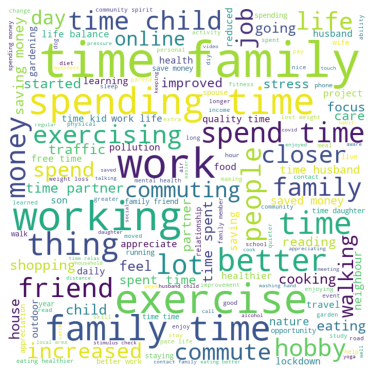

In [53]:
generate_wordcloud(positive_experience['processed_response'])

In [54]:
TextBlob(positive_experience['processed_response'][10]).ngrams(2)

[WordList(['opportunity', 'baby']),
 WordList(['baby', 'closer']),
 WordList(['closer', 'family']),
 WordList(['family', 'movie']),
 WordList(['movie', 'night']),
 WordList(['night', 'sex']),
 WordList(['sex', 'finish']),
 WordList(['finish', 'diy']),
 WordList(['diy', 'time']),
 WordList(['time', 'family']),
 WordList(['family', 'time']),
 WordList(['time', 'diy']),
 WordList(['diy', 'gardening'])]

In [55]:
# topic modelling
docs = list(positive_experience.loc[:,"processed_response"].values)

topic_model = BERTopic(language="english",verbose=True,embedding_model="all-MiniLM-L6-v2")

topics, probs = topic_model.fit_transform(docs)


ConnectionError: HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/models/sentence-transformers/all-MiniLM-L6-v2 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000256FB8057C0>: Failed to establish a new connection: [Errno 11002] getaddrinfo failed'))

In [56]:
topic_model.get_topic_info()

ValueError: This BERTopic instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [57]:
topic_model.get_topic_freq()

ValueError: This BERTopic instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [58]:
topic_model.visualize_barchart()

ValueError: This BERTopic instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

### Anything else comments analysis

In [59]:
comments_April20 = survey_April20[['anything_else']]
comments_April21 = survey_April21['anything_else']
comments = pd.concat([comments_April20,comments_April21],axis=1,join='inner')
comments.columns = ['comments_April20','comments_April21']
comments.dropna(axis = 0, how ='any',inplace=True)
comments                      

,comments_April20,comments_April21
ID,,
00769460,I am worried if I am going to be able to go ba...,Some people find it difficult to go back to wo...
00babb90,Mental health is declining and I cant see my f...,"normality and how we will adapt, social anxierty"
00db60f1,Some family members not observing social dista...,Worries they may be lonely
01297d76,My kids university education has been disrupte...,My kids are missing out on in-person learning ...
01808e74,Can't get a job.,Nothing.
...,...,...
fe76c64c,"I feel we'll all put on weight, and there will...","I feel it will impact nieces, and nephews work..."
fe977fb2,"I am not concerned about the Coronavirus, just...",I want life to get back to normal.
fea7af91,Nothing,Concerned about some of them being excessively...


In [60]:
comments['avg_length'] = comments['comments_April20'].str.len() + comments['comments_April20'].str.len()/len(comments.columns)
comments['avg_length'] = comments['avg_length'].astype(int)

In [61]:
comments.head()
#preprocess, stop words, punctuation, sentiment analysis, top words frequencies,topic modelinng

comments['avg_length'].describe()

count     728.000000
mean      244.350275
std       278.371052
min         3.000000
25%        94.000000
50%       171.000000
75%       300.250000
max      3625.000000
Name: avg_length, dtype: float64

array([[<AxesSubplot:title={'center':'avg_length'}>]], dtype=object)

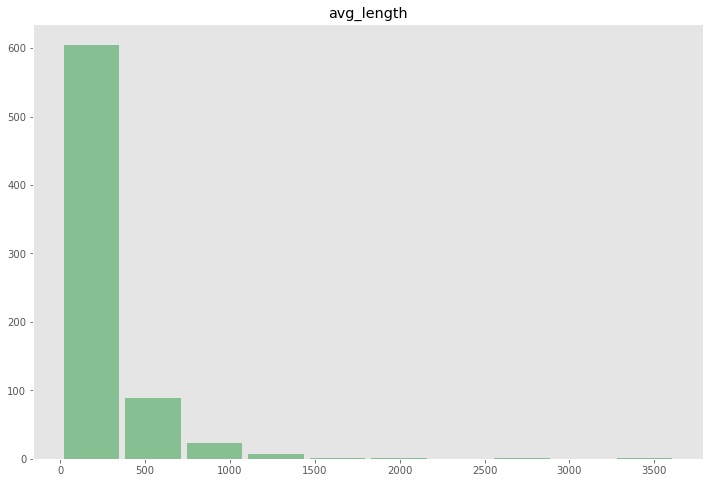

In [30]:
comments.hist(column='avg_length', bins=10, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

In [31]:
comments.head()

,comments_April20,comments_April21,avg_length
ID,,,
00769460,I am worried if I am going to be able to go ba...,Some people find it difficult to go back to wo...,100
00babb90,Mental health is declining and I cant see my f...,"normality and how we will adapt, social anxierty",135
00db60f1,Some family members not observing social dista...,Worries they may be lonely,97
01297d76,My kids university education has been disrupte...,My kids are missing out on in-person learning ...,259
01808e74,Can't get a job.,Nothing.,24


### Sentiment Analysis of comments [anything_else]

In [68]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def vader_sentiment_scores(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
#     print("Overall sentiment dictionary is : ", sentiment_dict)
    return sentiment_dict['compound']
     
    
#     print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative")
#     print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral")
#     print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive")
 
#     print("Sentence Overall Rated As", end = " ")
 
    # decide sentiment as positive, negative and neutral
def getvader_sentiment(score):    
    if score >= 0.05 :
        return "Positive"
 
    elif score <= - 0.05 :
        return "Negative"
 
    else :
        return "Neutral"


In [69]:
comments['sentiment_score_April20'] = comments['comments_April20'].apply(vader_sentiment_scores)
comments['sentiment_score_April21'] = comments['comments_April21'].apply(vader_sentiment_scores)

In [70]:
comments.head()

,comments_April20,comments_April21,avg_length,processed_commentsApril20,processed_commentsApril21,sentiment_score_April20,sentiment_score_April21
ID,,,,,,,
00769460,I am worried if I am going to be able to go ba...,Some people find it difficult to go back to wo...,100,worried going work,people find difficult work school emotionally ...,-0.2960,-0.5719
00babb90,Mental health is declining and I cant see my f...,"normality and how we will adapt, social anxierty",135,mental health declining cant family dont going,normality adapt social anxierty,0.0000,0.0000
00db60f1,Some family members not observing social dista...,Worries they may be lonely,97,family member observing social distancing rest...,worry lonely,0.0000,-0.6486
01297d76,My kids university education has been disrupte...,My kids are missing out on in-person learning ...,259,kid university education disrupted temporary r...,kid missing person learning university includi...,-0.6124,0.0000
01808e74,Can't get a job.,Nothing.,24,job,,0.0000,0.0000


In [71]:
comments['Polarity_April20'] = comments['sentiment_score_April20'].apply(getvader_sentiment)
comments['Polarity_April21'] = comments['sentiment_score_April21'].apply(getvader_sentiment)

In [72]:
comments.head()

,comments_April20,comments_April21,avg_length,processed_commentsApril20,processed_commentsApril21,sentiment_score_April20,sentiment_score_April21,Polarity_April20,Polarity_April21
ID,,,,,,,,,
00769460,I am worried if I am going to be able to go ba...,Some people find it difficult to go back to wo...,100,worried going work,people find difficult work school emotionally ...,-0.2960,-0.5719,Negative,Negative
00babb90,Mental health is declining and I cant see my f...,"normality and how we will adapt, social anxierty",135,mental health declining cant family dont going,normality adapt social anxierty,0.0000,0.0000,Neutral,Neutral
00db60f1,Some family members not observing social dista...,Worries they may be lonely,97,family member observing social distancing rest...,worry lonely,0.0000,-0.6486,Neutral,Negative
01297d76,My kids university education has been disrupte...,My kids are missing out on in-person learning ...,259,kid university education disrupted temporary r...,kid missing person learning university includi...,-0.6124,0.0000,Negative,Neutral
01808e74,Can't get a job.,Nothing.,24,job,,0.0000,0.0000,Neutral,Neutral


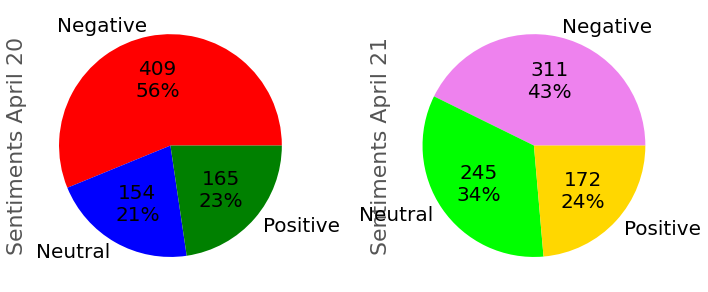

In [73]:
# plot sentiments side by side
def label_function(val):
    return f'{val / 100 * len(comments):.0f}\n{val:.0f}%'

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

comments.groupby('Polarity_April20').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 20},
                                  colors=['red', 'blue', 'green'], ax=ax1)
comments.groupby('Polarity_April21').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 20},
                                 colors=['violet', 'lime', 'gold'], ax=ax2)
ax1.set_ylabel('Sentiments April 20', size=22)
ax2.set_ylabel('Sentiments April 21', size=22)
plt.tight_layout()
plt.show()

In [74]:
#total word count frequecies

comments['processed_commentsApril20'] = comments['comments_April20'].apply(preprocess) 
comments['processed_commentsApril21'] = comments['comments_April21'].apply(preprocess)

from collections import Counter
Counter(" ".join(comments["processed_commentsApril20"]).split()).most_common(20)

[('family', 178),
 ('worried', 160),
 ('concerned', 142),
 ('people', 117),
 ('worry', 106),
 ('health', 103),
 ('friend', 88),
 ('virus', 88),
 ('work', 86),
 ('job', 81),
 ('concern', 66),
 ('long', 65),
 ('risk', 59),
 ('time', 56),
 ('going', 54),
 ('impact', 53),
 ('covid', 53),
 ('child', 52),
 ('thing', 50),
 ('member', 48)]

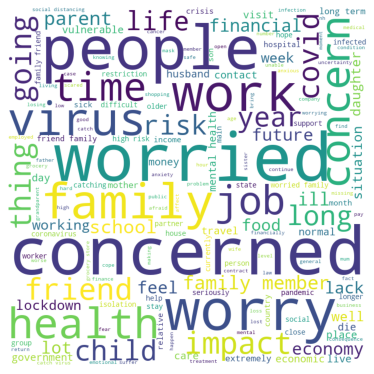

In [75]:

#looping through all incidents and joining them to one text, to extract most common words
generate_wordcloud(comments['processed_commentsApril20'])

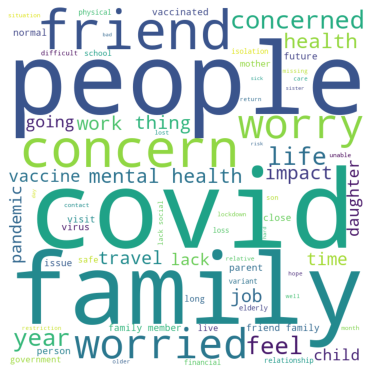

In [76]:

#looping through all incidents and joining them to one text, to extract most common words
generate_wordcloud(comments['processed_commentsApril21'])

In [90]:
## find participants with contradicting sentiments over the year

pos_to_neg = comments[(comments['Polarity_April20']  == 'Positive') & (comments['Polarity_April21']=='Negative')]
neg_to_pos = comments[(comments['Polarity_April20']  == 'Negative') & (comments['Polarity_April21']=='Positive')]
#comments.loc[comments['Polarity_April20'] == 'Positive' | comments['Polarity_April21']=='Negative']

In [94]:
pos_to_neg.shape

(63, 9)

In [97]:
#find key words, differences what made them change opinion

pos_to_neg.head()


,comments_April20,comments_April21,avg_length,processed_commentsApril20,processed_commentsApril21,sentiment_score_April20,sentiment_score_April21,Polarity_April20,Polarity_April21
ID,,,,,,,,,
0bc954cd,I had to cancel my wedding. I cannot travel t...,I had to resign from my job due to isolation.,240,cancel wedding travel visit family partner liv...,resign job isolation,0.4939,-0.6249,Positive,Negative
175f7afd,I just want to see my grandchildren,Lack of social life and holidays will depress ...,52,grandchild,lack social life holiday depress,0.0772,-0.4404,Positive,Negative
1bbe4324,Not being able to see my boyfriend or friends....,"I worry about their mental health, it's been a...",186,boyfriend friend knowing job thing finally normal,worry mental health big change,0.4767,-0.4404,Positive,Negative
1deee505,I am concerned about the Government's exit str...,I am worried that Covid 19 may last many years...,144,concerned government exit strategy affect loved,worried covid 19 year mutate deadly,0.5994,-0.2960,Positive,Negative
20d46473,Loosing closeness of relationships with friend...,I don't want any of my family to catch covid a...,148,loosing closeness relationship friend parent s...,family catch covid suffer financial implication,0.1531,-0.5750,Positive,Negative


In [93]:
neg_to_pos.shape

(104, 9)